In [3]:
### Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Epoch 1/50
374/374 - 54s - loss: 0.0449 - 54s/epoch - 145ms/step
Epoch 2/50
374/374 - 52s - loss: 0.0127 - 52s/epoch - 140ms/step
Epoch 3/50
374/374 - 51s - loss: 0.0093 - 51s/epoch - 136ms/step
Epoch 4/50
374/374 - 66s - loss: 0.0079 - 66s/epoch - 177ms/step
Epoch 5/50
374/374 - 66s - loss: 0.0070 - 66s/epoch - 177ms/step
Epoch 6/50
374/374 - 54s - loss: 0.0063 - 54s/epoch - 143ms/step
Epoch 7/50
374/374 - 43s - loss: 0.0059 - 43s/epoch - 114ms/step
Epoch 8/50
374/374 - 44s - loss: 0.0053 - 44s/epoch - 117ms/step
Epoch 9/50
374/374 - 60s - loss: 0.0050 - 60s/epoch - 160ms/step
Epoch 10/50
374/374 - 46s - loss: 0.0046 - 46s/epoch - 123ms/step
Epoch 11/50
374/374 - 40s - loss: 0.0044 - 40s/epoch - 107ms/step
Epoch 12/50
374/374 - 41s - loss: 0.0040 - 41s/epoch - 109ms/step
Epoch 13/50
374/374 - 40s - loss: 0.0039 - 40s/epoch - 106ms/step
Epoch 14/50
374/374 - 44s - loss: 0.0038 - 44s/epoch - 117ms/step
Epoch 15/50
374/374 - 42s - loss: 0.0039 - 42s/epoch - 114ms/step
Epoch 16/50
374/374

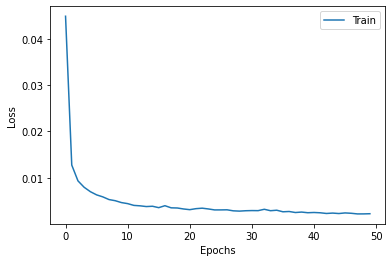

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               93600     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 5, 150)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 5, 100)            100400    
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 5)             505       
 tributed)                                                       
                                                                 
Total params: 194,505
Trainable params: 194,505
Non-trainable params: 0
_________________________________________________________________
Feature Tank2OutFlow:
Mean Squared Error: 0.1262

In [4]:
### Plot function
def plot_multiple_series(actual, pred, attr):
    if len(actual) != len(pred):
        return "Error: The lengths of the two data must be the same!"
    x = range(len(pred))
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(x, actual.iloc[:,i], label="actual")
        plt.plot(x, pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()


### Visualise the data
# file_name = "phy_cps.csv"
file_name = 'waterTank_Golden_reduced.csv'
attr = list(pd.read_csv(file_name).columns.values)[1:]

mse_list = []
rmse_list = []
mae_list = []
rsqr_list = []


# Load and preprocess data
data = pd.read_csv(file_name, header=0, index_col=0)
raw_data = data.values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(raw_data)

# Split data into train and test sets
# train_size = int(len(data) * 0.7)
# train_size = 12000
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data),:]

# Define the number of time steps and features
# n_steps_in = 100
# n_steps_out = 10
n_steps_in = 30
n_steps_out = 5
n_features = data.shape[1]

# Reshape data for LSTM
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix-1:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)

# Define the LSTM model
model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(LSTM(150, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(n_features)))

# Compile and fit the model
# model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='RMSprop', loss='mse')
train_history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print("Model's Mean Squared Error:", mse)

# Make predictions on test data
y_pred = model.predict(X_test)

# Reshape predictions for inverse scaling
# y_pred_reshaped = y_pred.reshape((y_pred.shape[0]*y_pred.shape[1], n_steps_out, n_features))
# y_test_reshaped = y_test.reshape((y_test.shape[0]*y_test.shape[1], n_steps_out, n_features))

# Extract only the result of prediction for n_steps_out=3
result_pred = y_pred[:, -n_steps_out:, :]

# Reshaping


# Inverse scale predictions and test data
result_pred_inv = scaler.inverse_transform(result_pred.reshape(-1, n_features))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, n_features))

# print(result_pred_inv.shape)
# print(result_pred_inv)
# Calculate RMSE
# rmse = np.sqrt(np.mean((y_pred_inv - y_test_inv)**2))
rmse = np.sqrt(np.mean((result_pred_inv - y_test_inv)**2))
print('Root Mean Squared Error:', rmse)

# Plot curve
print("----------Learning Curve----------")
plt.plot(train_history.history['loss'], label='Train')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

for i in range(1, len(attr)+1):
    print(f'Feature {data.columns[i-1]}:')
    mse = mean_squared_error(y_test_inv[i], result_pred_inv[i])
    mse_list.append(mse)
    print(f'Mean Squared Error: {mse}')

    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f'Root Mean Squared Error: {rmse}')

    mae = mean_absolute_error(y_test_inv[i], result_pred_inv[i])
    mae_list.append(mae)
    print(f'Mean Absolute Error: {mae}')

    r_sqr = r2_score(y_test_inv[i], result_pred_inv[i])
    rsqr_list.append(r_sqr)
    print(f'R2 Score: {r_sqr}\n')


In [ ]:
train_size

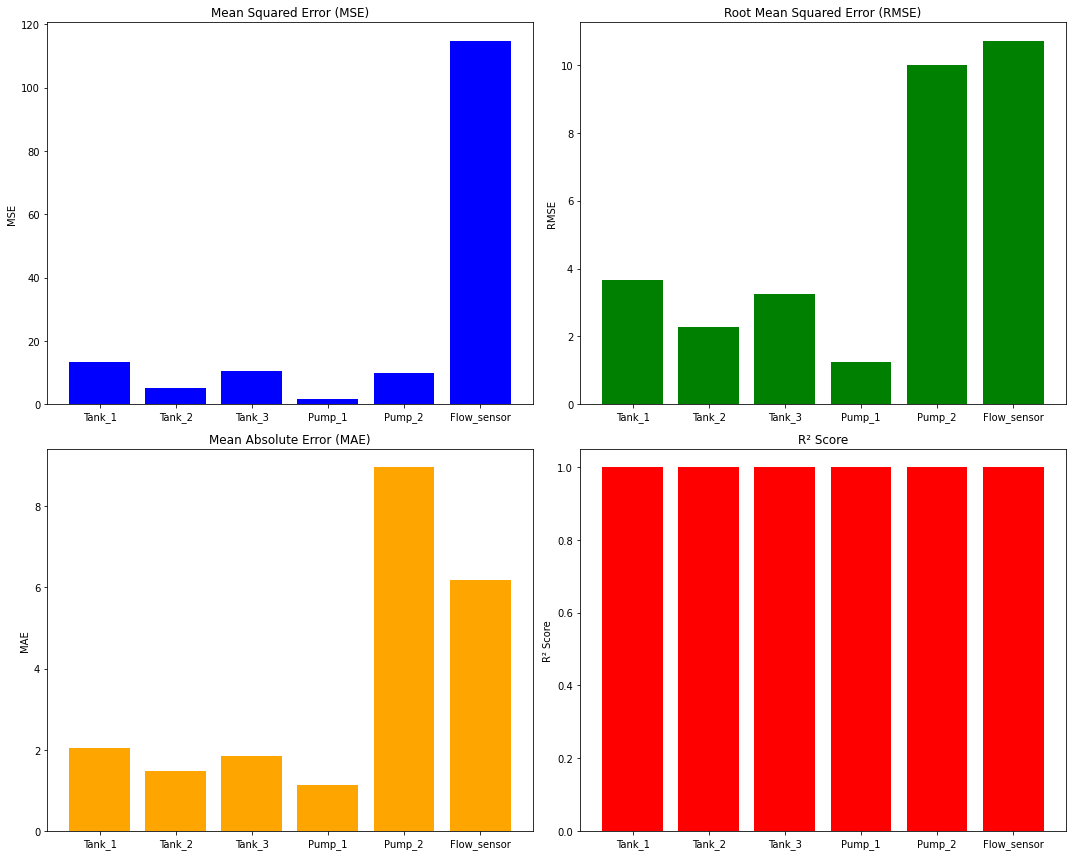

In [13]:
import matplotlib.pyplot as plt

# Define the metrics
features = ['Tank_1', 'Tank_2', 'Tank_3', 'Pump_1', 'Pump_2', 'Flow_sensor']
mse = [13.3672, 5.1784, 10.6433, 1.5652, 9.9912, 114.85]
rmse = [3.6561, 2.2756, 3.2624, 1.2511, 9.9956, 10.7168]
mae = [2.0374, 1.4680, 1.8357, 1.1395, 8.9622, 6.1795]
r2_score = [0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999]

# Plot the metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot MSE
axes[0, 0].bar(features, mse, color='blue')
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
axes[0, 1].bar(features, rmse, color='green')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot MAE
axes[1, 0].bar(features, mae, color='orange')
axes[1, 0].set_title('Mean Absolute Error (MAE)')
axes[1, 0].set_ylabel('MAE')

# Plot R2 Score
axes[1, 1].bar(features, r2_score, color='red')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R² Score')

# Adjust layout
plt.tight_layout()
plt.show()


### Plots for simulated data forecasting using LSTM

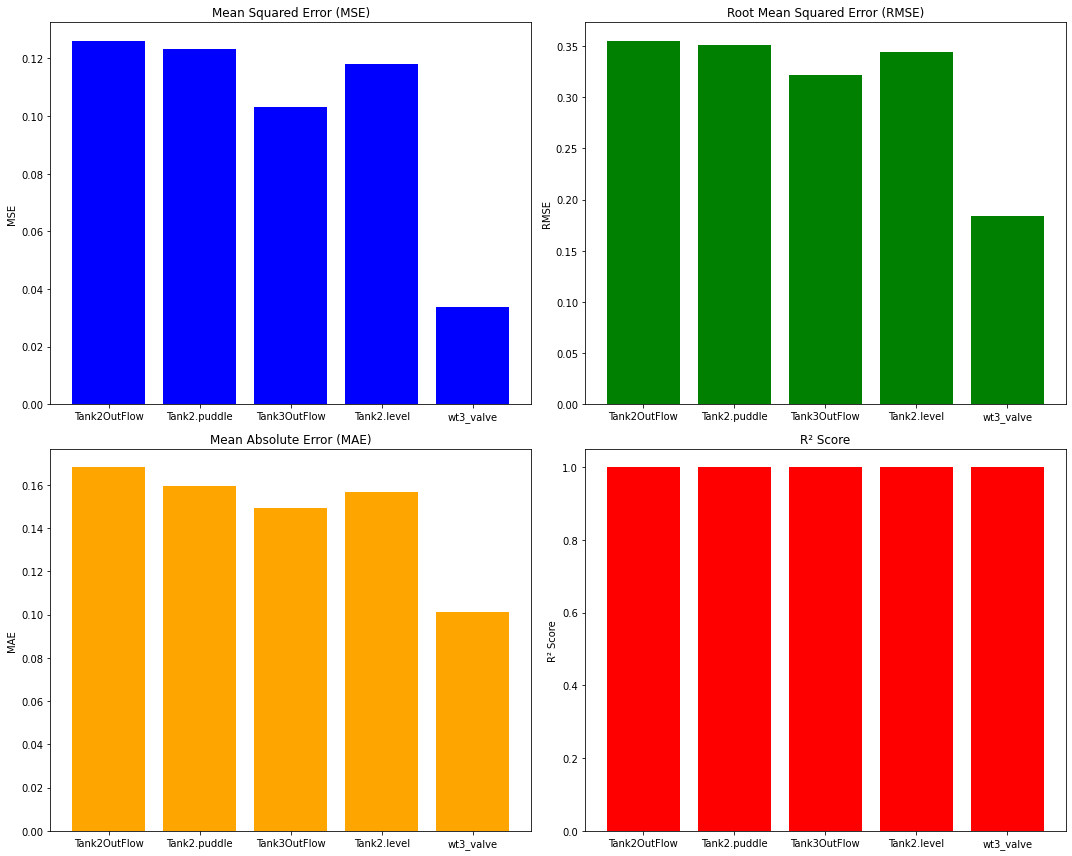

In [6]:
import matplotlib.pyplot as plt

# Define the metrics for the new features
features = ['Tank2OutFlow', 'Tank2.puddle', 'Tank3OutFlow', 'Tank2.level', 'wt3_valve']
mse = [0.12620951419855053, 0.12329669258281686, 0.10325490800087005, 0.11823882687843552, 0.033733498981814776]
rmse = [0.355259784099679, 0.35113628776134326, 0.3213330172902717, 0.34385873099055597, 0.18366681513494695]
mae = [0.1682122160899408, 0.15946966954244926, 0.14949298387985893, 0.1568083480114844, 0.10139344737922915]
r2_score = [0.9994323328526845, 0.9994467575711716, 0.9995382548911985, 0.9994723695887912, 0.9998482729352254]

# Plot the metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot MSE
axes[0, 0].bar(features, mse, color='blue')
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
axes[0, 1].bar(features, rmse, color='green')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot MAE
axes[1, 0].bar(features, mae, color='orange')
axes[1, 0].set_title('Mean Absolute Error (MAE)')
axes[1, 0].set_ylabel('MAE')

# Plot R2 Score
axes[1, 1].bar(features, r2_score, color='red')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R² Score')

# Adjust layout
plt.tight_layout()
plt.show()


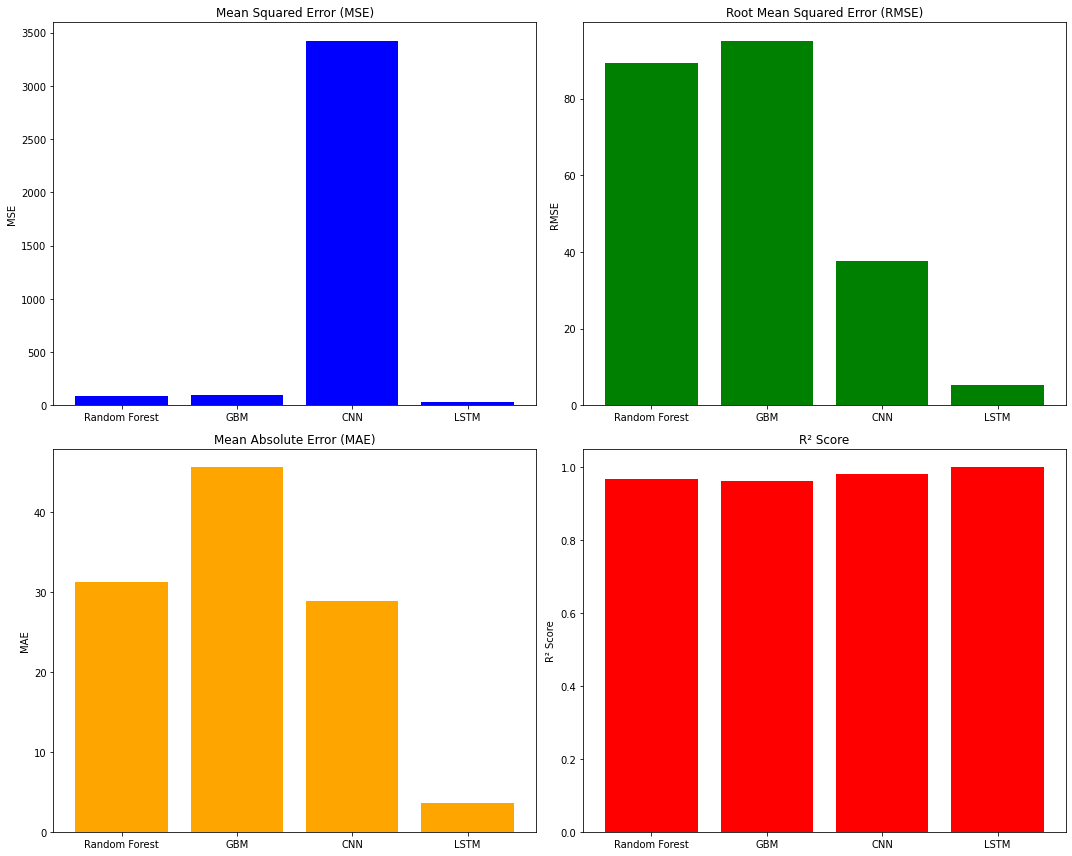

In [9]:
import matplotlib.pyplot as plt

# Define the metrics
models = ['Random Forest', 'GBM', 'CNN', 'LSTM']
mse = [83.3506, 98.6888, 3425.395, 25.9325]
rmse = [89.2637, 95.1497, 37.7053, 5.1929]
mae = [31.2487, 45.5806, 28.8733, 3.6037]
r2_score = [0.9667, 0.9623, 0.9814, 0.9999]

# Plot the metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot MSE
axes[0, 0].bar(models, mse, color='blue')
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
axes[0, 1].bar(models, rmse, color='green')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot MAE
axes[1, 0].bar(models, mae, color='orange')
axes[1, 0].set_title('Mean Absolute Error (MAE)')
axes[1, 0].set_ylabel('MAE')

# Plot R2 Score
axes[1, 1].bar(models, r2_score, color='red')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R² Score')

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Data for each feature
# features = ['Tank1', 'Tank2', 'Tank3', 'Pump1', 'Pump2', 'FlowSensor']
# methods = ['Random Forest', 'GBM', 'CNN', 'LSTM']
# mse = [
#     [50.7164, 11.4495, 2.0653e+03, 13.3672],  # Tank1
#     [128.85, 8.7459, 1.078e+04, 5.1784],     # Tank2
#     [61.3287, 548.1675, 5.9769e+04, 10.6433], # Tank3
#     [0.0022, 1.5774, 2.7658e+03, 1.6562],     # Pump1
#     [0.0147, 1.2108, 7.5243e+03, 9.0912],     # Pump2
#     [259.91, 268.6549, 8.9249e+03, 1.1485e+02] # FlowSensor
# ]
# rmse = [
#     [7.1215, 3.2828, 45.4452, 3.6561], 
#     [11.3513, 2.9574, 103.74, 2.2786], 
#     [7.8313, 548.1675, 244.50, 3.2615], 
#     [0.0464, 1.2574, 52.638, 1.287], 
#     [0.1214, 1.1007, 86.68, 2.999], 
#     [16.1139, 268.6549, 94.70, 10.7187]
# ]
# mae = [
#     [4.1202, 2.0509, 27.4692, 2.0374], 
#     [7.4276, 2.0437, 72.7169, 1.4680], 
#     [4.1142, 247.6187, 50.0672, 8.8357], 
#     [0.0464, 0.1574, 32.7685, 1.1959], 
#     [0.1214, 0.1007, 51.9487, 0.7168], 
#     [6.1307, 16.4359, 66.9665, 3.4097]
# ]

# # Plotting
# x = np.arange(len(features))  # the label locations
# width = 0.15  # the width of the bars

# fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# # Colors for the bars
# colors = ['blue', 'orange', 'green', 'red']

# # Titles and data for each metric
# titles = ['MSE', 'RMSE', 'MAE']
# data = [mse, rmse, mae]

# for i, ax in enumerate(axes):
#     for j, method in enumerate(methods):
#         ax.bar(x + width * (j - 1.5), [data[i][k][j] for k in range(len(features))], width, label=method, color=colors[j])
#     ax.set_title(titles[i])
#     ax.set_ylabel('Value')
#     ax.legend()

# axes[-1].set_xticks(x)
# axes[-1].set_xticklabels(features)
# fig.suptitle('Comparison of Error Metrics for Different Features')
# fig.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()
